<a href="https://colab.research.google.com/github/graphitical/HeadsUP/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset generation

This file is intended to help with the creation of the HeadsUP dataset. This is a dataset that has been bootstrapped with PubLayNet (detectron2) and then augmented with HTML paper information to give more granular information regarding the title header levels in PDF papers.

The generation of the dataset was done with the CHI 2019 Procedings, which helpfully provided the HTML and PDF versions of the same papers. Using PubLayNet we were able to parse the CHI 2019 papers to determine the components of the papers such as figures, tables, etc.

The key factor we care about is what PubLayNet calls "titles." Titles in PLN are actually any kind of header text. This includes the title of the paper but also section headers and if the network is incorrect, figure headings. The HTML version of the papers helpfully provides header levels explicitly as H1, H2, & H3. 

We used PLN to parse the CHI 2019 papers and give us annotations/segmentations of the different "titles". We then perform OCR on the segments that PLN determined were titles. We can cross correlate this OCR text then with the HTML files to get header levels. We then modify the HeadsUP dataset with this new information, bootstrapping our way to a useful data set.

This is actually all an effort to retrain PLN to perform this task automatically. The final goal is to use this bootstrapped dataset to then transer learn PLN so that it all comes out as it should straight from the network with proper heading levels already known.

# Install detectron2

In [10]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__)

gpu_available = torch.cuda.is_available()
if gpu_available:
  device = 'cuda'
else:
  device = 'cpu'
print('CUDA enabled:', gpu_available)

!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101
CUDA enabled: True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [11]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [12]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import matplotlib.pyplot as plt
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Mount Google Drive

In [18]:
# Use this to mount your google account that has
# access to the shared drive
import os, sys, datetime
from google.colab import drive
drive.mount('/gdrive')

# Change dir to shared drive
BASE_PATH = '/gdrive/Shareddrives/deep learning and PDF accessibility/'
DATA_PATH = 'dataset/CHI-2019/'
os.chdir(BASE_PATH)
!pwd 

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/Shareddrives/deep learning and PDF accessibility


# Load model

## Helper functions

In [14]:
def setup_cfg(config, weights, thresh = 0.5, device = 'cpu'):
    # load config from file and command-line arguments
    cfg = get_cfg()
    cfg.merge_from_file(config)
    # Set score_threshold for builtin models
    cfg.MODEL.WEIGHTS = weights
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = thresh
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = thresh
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = thresh
    cfg.MODEL.DEVICE = device
    cfg.freeze()
    return cfg

In [15]:
# These are detection class defintions
# Examples are text, title, etc.
# Will need to expand for our training
MetadataCatalog.get("dla_val").thing_classes = ['text','title','list','table','figure']

# BIG MODEL
config = BASE_PATH + 'configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml'
weights = BASE_PATH + 'configs/resnext101.pth'

# LITTLE MODEL
# config = BASE_PATH + 'configs/DLA_mask_rcnn_R_50_FPN_3x.yaml'
# weights = BASE_PATH + 'configs/resnet50.pth'

cfg = setup_cfg(config, weights, device=device)
predictor = DefaultPredictor(cfg)

WARNING [12/17 06:36:13 d2.config.compat]: Config '/gdrive/Shareddrives/deep learning and PDF accessibility/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


# Demo
## Predict

In [21]:
# Want to loop here, but can hard code for debugging
fname = os.path.join(BASE_PATH,DATA_PATH,'CHI-2019-jpegs/AdaCADCraftingSoftwareforSmartTextilesDesign-0.jpeg')
im = cv2.imread(fname)
# cv2_imshow(im)
outputs = predictor(im)
# print(type(outputs['instances']))

## Visualize

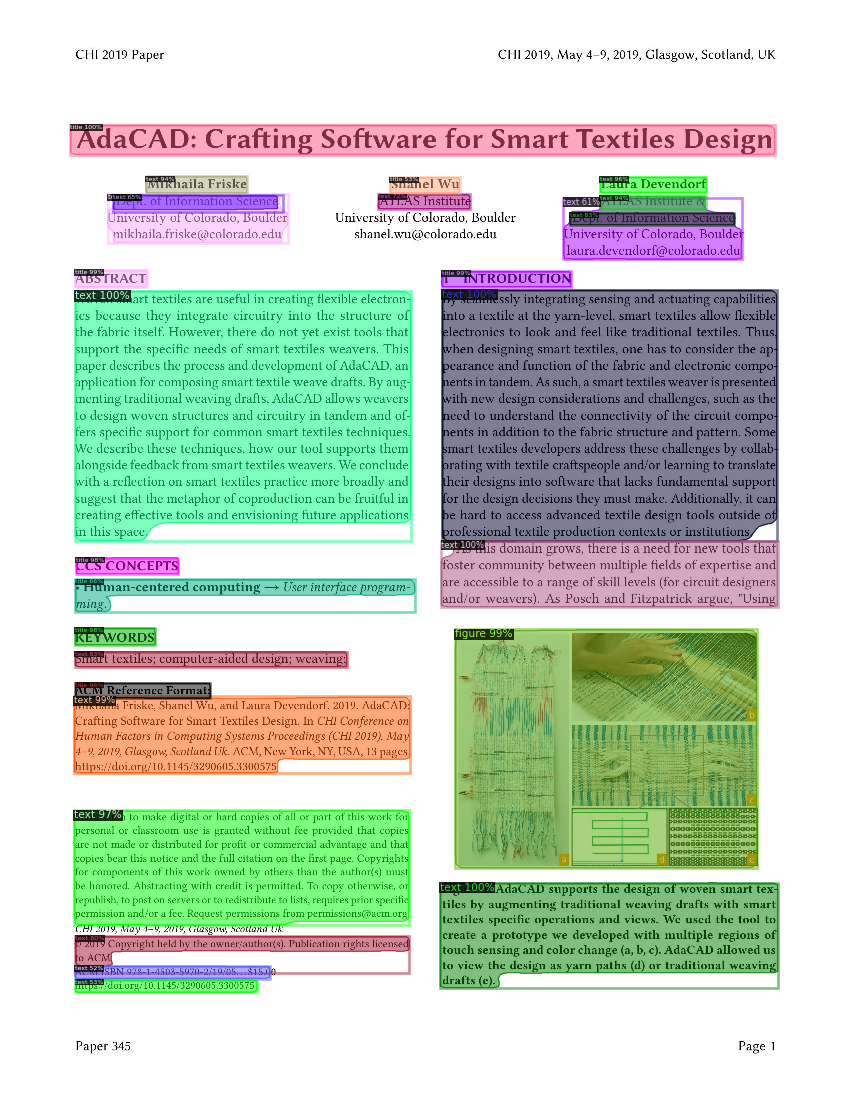

In [32]:
def visualize_output(img, outputs, scale=0.5):
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get('dla_val'), scale=scale)
    out = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    cv2_imshow(out.get_image()[:, :, ::-1])

visualize_output(im, outputs)

In [ ]:
print(outputs['instances'])
print()
# print(outputs['instances'].pred_boxes)
# import matplotlib.pyplot as plt
# print(outputs['instances'].pred_masks[0].cpu().numpy())
# plt.imshow(outputs['instances'].pred_masks[0].cpu().numpy())

Instances(num_instances=25, image_height=2200, image_width=1700, fields=[pred_boxes: Boxes(tensor([[ 885.0526, 1158.1091, 1552.7994, 1803.5057],
        [ 884.4844,  585.6922, 1555.2760, 1168.6219],
        [ 151.5337,  587.2892,  821.2396, 1104.8566],
        [ 882.2260, 1805.9578, 1553.9736, 1925.9667],
        [ 154.8795,  223.3707, 1551.1799,  329.4218],
        [ 150.6207,  544.6706,  311.6027,  580.0060],
        [ 882.8649,  546.4799, 1169.7883,  580.0873],
        [ 150.4806, 1482.7781,  820.4676, 1621.7957],
        [ 150.1720, 1143.0869,  375.9620, 1177.4451],
        [ 149.4797, 1316.0665,  321.6097, 1350.1097],
        [ 150.6470, 1457.2043,  389.2528, 1484.2581],
        [ 147.6463, 1357.7472,  822.3192, 1418.2106],
        [ 147.7524, 1720.5453,  821.5641, 1886.1089],
        [ 152.4536, 1880.9209,  572.1400, 1902.3679],
        [ 144.5269, 1902.4952,  805.5001, 1944.1882],
        [1103.0291,  354.5697, 1283.6801,  391.2786],
        [ 441.8999,  354.5528,  576.8441,  39

# Create dataset

## Get pycococreator module

In [23]:
!pip install git+git://github.com/waspinator/pycococreator.git@0.2.0
from pycococreatortools import pycococreatortools as pcc

  Cloning git://github.com/waspinator/pycococreator.git (to revision 0.2.0) to /tmp/pip-req-build-w16g2wcm
  Running command git clone -q git://github.com/waspinator/pycococreator.git /tmp/pip-req-build-w16g2wcm
  Running command git checkout -q fba8f4098f3c7aaa05fe119dc93bbe4063afdab8
  Created wheel for pycococreatortools: filename=pycococreatortools-0.2.0-cp36-none-any.whl size=7191 sha256=383ba7c3c616f0e0275fe2bf152082994522b10df79a4726f4cd8a24752ff189
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_0ak19x/wheels/ad/8a/49/9cda5b77c0aec14230df33a9ddfaf60bf488f08a311a2aec0f
Successfully built pycococreatortools


## Dataset Boilerplate Info

In [74]:
INFO = {
    "description": "HeadsUP Dataset",
    "url": "TBD",
    "version": "0.0.0",
    "year": 2020,
    "contibutor": ["graphitical", "venkateshpotluri", "tgotfrid"],
    "date_created": datetime.datetime.utcnow().isoformat(' ')
}

LICENSES = [
  {
      "id": 1,
      "name": "Attribution-NonCommercial-ShareAlike License",
      "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
  }
]

# Will need to update
CATEGORIES = [
  {
      "id": 0,
      "name": "text",
      "supercategory": ""
  },
  {
      "id": 1,
      "name": "title",
      "supercategory": ""
  },
  {
      "id": 2,
      "name": "list",
      "supercategory": ""
  },
  {
      "id": 3,
      "name": "table",
      "supercategory": ""
  },
  {
      "id": 4,
      "name": "figure",
      "supercategory": ""
  },
  {
      "id": 5,
      "name": "H1",
      "supercategory": ""
  },
  {
      "id": 6,
      "name": "H2",
      "supercategory": ""
  },
  {
      "id": 7,
      "name": "H3",
      "supercategory": ""
  },
  {
      "id": 8,
      "name": "H4",
      "supercategory": ""
  },
  {
      "id": 9,
      "name": "H5",
      "supercategory": ""
  }
]

## Dataset Generation

5841 files in /gdrive/Shareddrives/deep learning and PDF accessibility/dataset/CHI-2019/CHI-2019-jpegs
Image 0


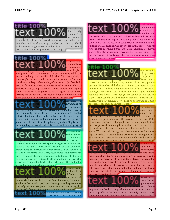

{'info': {'description': 'HeadsUP Dataset', 'url': 'TBD', 'version': '0.0.0', 'year': 2020, 'contibutor': ['graphitical', 'venkateshpotluri', 'tgotfrid'], 'date_created': '2020-12-17 07:57:28.677737'}, 'licenses': [{'id': 1, 'name': 'Attribution-NonCommercial-ShareAlike License', 'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/'}], 'categories': [{'id': 0, 'name': 'text', 'supercategory': ''}, {'id': 1, 'name': 'title', 'supercategory': ''}, {'id': 2, 'name': 'list', 'supercategory': ''}, {'id': 3, 'name': 'table', 'supercategory': ''}, {'id': 4, 'name': 'figure', 'supercategory': ''}, {'id': 5, 'name': 'H1', 'supercategory': ''}, {'id': 6, 'name': 'H2', 'supercategory': ''}, {'id': 7, 'name': 'H3', 'supercategory': ''}, {'id': 8, 'name': 'H4', 'supercategory': ''}, {'id': 9, 'name': 'H5', 'supercategory': ''}], 'images': [{'id': 0, 'file_name': 'EncodingMaterialsandDataforIterativePersonalization-8.jpeg', 'width': 2200, 'height': 1700, 'date_captured': '2020-12-17 06:56:34.82

KeyboardInterrupt: ignored

In [83]:
from pathlib import Path
import json

def write_labels(coco_output, out_id='final'):
  fpath = os.path.join(BASE_PATH,DATA_PATH,'labels-{}.json'.format(out_id))
  with open(fpath, 'w') as fp:
    print('Writing labels-{}'.format(out_id))
    json.dump(coco_output, fp, indent=4)


def_coco_output = {
    'info': INFO, 
    'licenses': LICENSES, 
    'categories': CATEGORIES, 
    'images': [], 
    'annotations': []
}

import copy
coco_output = copy.deepcopy(def_coco_output)
big_coco = copy.deepcopy(def_coco_output)


ann_id = 0
img_id = 0
out_id = 0

# dirs to search for image files
# DIRS = ['images/ASSETS_paper/']
DIRS = [os.path.join(BASE_PATH,DATA_PATH,'CHI-2019-jpegs')]

for DIR in DIRS:
  print('{} files in {}'.format(len(os.listdir(DIR)),DIR))
  for image_path in Path(DIR).rglob('*.jpeg'):
    image = cv2.imread(str(image_path))
    image_info = pcc.create_image_info(img_id, image_path.name, image.shape)

    big_coco['images'].append(image_info)
    coco_output['images'].append(image_info)

    # Predict Output
    pred = predictor(image)

    # Loop over annotations found in image
    boxes, bin_masks, cats = pred['instances'].pred_boxes, pred['instances'].pred_masks, pred['instances'].pred_classes
    for box, mask, cat in zip(boxes, bin_masks, cats):
      cat_info = {'id': cat.item(), 'is_crowd': 0 }
      annotation_info = pcc.create_annotation_info(ann_id, img_id, cat_info, mask.cpu().numpy().astype(int), image.shape[:2], bounding_box=box)
    
      if annotation_info is not None:
        coco_output['annotations'].append(annotation_info)
        big_coco['annotations'].append(annotation_info)
        ann_id += 1

    # write intermediate file in case something has gone wrong
    # also visualize an output to show that things are changing
    if img_id % 10 == 0 and img_id > 0:
      write_labels(coco_output, out_id)
      coco_output = copy.deepcopy(def_coco_output)
      out_id += 1

    if img_id % 5 == 0:
      print('Image',img_id)

    if img_id % 50 == 0:
      visualize_output(image, pred, scale=0.1)

    # On to the next image!
    # print('Image',img_id)
    img_id += 1
    # if img_id > 100: break # debugging

if img_id == 1: print(big_coco)

# cross your fingers and hope it works
# might as well try writing the whole sheband at once too
write_labels(big_coco)

## OCR

In [ ]:
# Get pytesseract
! pip install pytesseract

# Useful references
1. [Fine tune model](https://github.com/hpanwar08/detectron2/issues/25)
1. [How to make a COCO dataset](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch)
1. [PyCoCoCreator](https://github.com/waspinator/pycococreator)
